In [2]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 30 10:51:32 2020

@author: Dypole_Imaging
"""
import numpy as np
import mysql.connector
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
"""
imageID of P = 100mW / 2.5GHz red / spin mixuture 77939 - 78010
imageID of P = 100mW / 2.5GHz red / non spin polarized 78013 - 
"""

MYSQLserverIP = "192.168.1.133"
username = "root"
password = "w0lfg4ng"
databaseName = "dypoledatabase"

typeOfConnection = "global"
#### Used functions ####

def dataToArray(pathFile):
    # Convert camera fits data to binary format
    with open(pathFile, 'rb') as file:
        image = fits.getdata(file)
    return image[0].ravel().tolist(), image[1].ravel().tolist(), image[2].ravel().tolist()   # atoms, noAtoms, dark

def updateNewImage():
    db = setConnection()
    cursor = db.cursor()
    sql_query = """UPDATE updates SET newImage = 1 WHERE idUpdates = 0;"""
    cursor.execute(sql_query)
    db.commit()
    cursor.close()
    db.close()

def getLastID():
    sql_query = """SELECT runID FROM ciceroOut ORDER BY runID DESC LIMIT 1;"""
    lastRunID = executeGetQuery(sql_query)[0][0]
    sql_query = """SELECT sequenceID FROM sequence ORDER BY sequenceID DESC LIMIT 1;"""
    lastSequenceID = executeGetQuery(sql_query)[0][0]
    return lastRunID, lastSequenceID

def getLastImageID():
    sql_query = """SELECT imageID FROM images ORDER BY imageID DESC LIMIT 1;"""
    lastImageID = executeGetQuery(sql_query)[0][0]
    return lastImageID

def getTimestamp(imageID):
    sql_query = "SELECT timestamp FROM images WHERE imageID = " + str(imageID) + ";"
    timestamp = executeGetQuery(sql_query)[0][0]
    return timestamp

def getLastImageIDs(n):
    sql_query = """SELECT imageID FROM images ORDER BY imageID DESC LIMIT """ + str(n) + """;"""
    lastImageIDsTupleList = executeGetQuery(sql_query)
    lastImageIDs = listTupleToList(lastImageIDsTupleList)
    return lastImageIDs

def listTupleToList(List):
    outputList = []
    for oneTuple in List:
        outputList += [oneTuple[0]]
    return outputList

def setConnection(typeOfConnection = 'global'):
    if typeOfConnection == 'local':
        return setLocalConnection()
    elif typeOfConnection == 'global':
        return setDistantConnection()
    else:
        print('Set what type of connection you want')

def setLocalConnection():
    # Open database connection
    mydb = mysql.connector.connect(host = "localhost",
                        user = "student",
                        password = "w0lfg4ng",
                        database = "imagesdypoledatabase")
    #print('Local connection established')
    return mydb

def setDistantConnection():
    # Open database connection
    mydb = mysql.connector.connect(host = MYSQLserverIP,
                        user = username,
                        password = password,
                        database = databaseName)
    #print('Distant connection established')
    return mydb

def getRunIDFromImageID(imageID):
    sql_query = "SELECT runID_fk FROM images WHERE imageID = {} ;".format(imageID)
    runID_fk = executeGetQuery(sql_query)[0][0]
    return runID_fk

def getNCount(imageID):
    try:
        runID_fk = getRunIDFromImageID(imageID)
        sql_query = "SELECT nCount FROM nCounts WHERE runID_fk = {} ;".format(runID_fk)
        nCount = executeGetQuery(sql_query)[0][0]
    except:
        nCount = 0.0
    return nCount

def executeGetQuery(sql_query): # works when you don't need to use db.commit, so for read only functions
    db = setConnection()
    cursor = db.cursor()
    cursor.execute(sql_query)
    cursorResult = cursor.fetchall()
    cursor.close()
    db.close()
    return cursorResult

In [41]:
getNCount(78025)

57453.0

In [140]:
def getNCountList(imageIDList):
    NCounts = np.zeros(len(imageIDList))
    i = 0
    for imageID in imageIDList:
        NCounts[i] = getNCount(imageID)
        i += 1
    return NCounts

def getHoldTime(imageID):
    runID = getRunIDFromImageID(imageID)
    sql_query = "SELECT BECHoldTime FROM ciceroOut WHERE runID = {} ;".format(runID)
    holdTime = executeGetQuery(sql_query)[0][0]
    return holdTime

def getHoldTimeList(imageIDList):
    holdTimeList = np.zeros(len(imageIDList))
    i = 0
    for imageID in imageIDList:
        holdTimeList[i] = getHoldTime(imageID)
        i += 1
    return holdTimeList

imageIDList_Mixture_data = np.array(list(range(77939,78010+1)))
NCountList_Mixture_data = getNCountList(imageIDList_Mixture)
holdTimeList_Mixture_data = getHoldTimeList(imageIDList_Mixture)

imageIDList_Polarized_data = np.array(list(range(78013,78084+1)))
NCountList_Polarized_data = getNCountList(imageIDList_Polarized)
holdTimeList_Polarized_data = getHoldTimeList(imageIDList_Polarized)

In [151]:
# NCountList_Mixture = NCountList_Mixture_data[holdTimeList_Mixture_data < 40]
# holdTimeList_Mixture = (holdTimeList_Mixture_data - min(holdTimeList_Mixture_data))[holdTimeList_Mixture_data < 40]
# NCountList_Polarized = NCountList_Polarized_data[holdTimeList_Polarized_data < 40]
# holdTimeList_Polarized = (holdTimeList_Polarized_data - min(holdTimeList_Polarized_data))[holdTimeList_Polarized_data < 40]

NCountList_Mixture = NCountList_Mixture_data
holdTimeList_Mixture = (holdTimeList_Mixture_data - min(holdTimeList_Mixture_data))
NCountList_Polarized = NCountList_Polarized_data
holdTimeList_Polarized = (holdTimeList_Polarized_data - min(holdTimeList_Polarized_data))

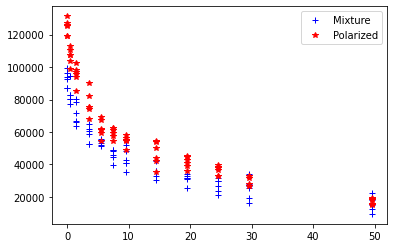

In [152]:
plt.figure()
#plt.plot(imageIDList, getNCountList(imageIDList))
plt.plot(holdTimeList_Mixture, NCountList_Mixture, '+', color = 'blue', label = 'Mixture')
plt.plot(holdTimeList_Polarized, NCountList_Polarized, '*', color = 'red', label = 'Polarized')
plt.legend()
plt.show()

We fit the polarized sample to $dN/dt = -\alpha N-\gamma N^{3}$, so $N(t) = \frac{\sqrt{\alpha}}{\sqrt{e^{2\alpha t}\left(\frac{a}{N(0)^{2}}+\gamma\right)-\gamma}}$ and the mixture one to $dN/dt = -\alpha N - \beta N^{2} -\gamma N^{3}$, so $N(t) = complicated$

In [169]:
def N_polarized(t, N0, alpha, gamma):
    return np.sqrt(alpha / (np.exp(2*alpha*t)*(alpha/(N0**2)+gamma)-gamma))
N0_guess = max(NCountList_Polarized)
time_guess = max(holdTimeList_Polarized)
N0_min = NCountList_Polarized[holdTimeList_Polarized == 0.5].mean()
popt, pcov = curve_fit(N_polarized, holdTimeList_Polarized, NCountList_Polarized,
                       p0 = [N0_guess, 1/time_guess, 1/(N0_guess**2*time_guess)],
                       bounds=([0, 0, 0] , [np.inf, np.inf, np.inf])
                      )
perr = np.sqrt(np.diag(pcov))
print(popt)
print(perr)
print("The ratio between exponential decay / 3-body decay is " + str(round(popt[2]*(popt[0])**2/(popt[1]),1)))

[1.35113710e+05 1.86579042e-03 5.63527322e-12]
[8.77281160e+03 6.77043948e-03 1.03169427e-09]
The ratio between exponential decay / 3-body decay is 55.1


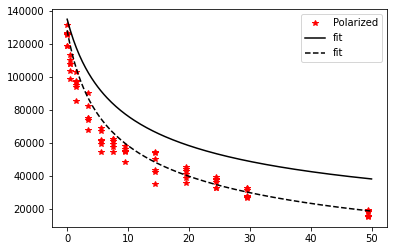

In [168]:
holdTimeList = np.linspace(0, 50, 200)
plt.figure()
plt.plot(holdTimeList_Polarized, NCountList_Polarized, '*', color = 'red', label = 'Polarized')
plt.plot(holdTimeList, N_polarized(holdTimeList, popt[0], popt[1], popt[2]), '-', color = 'black', label = 'fit')
plt.plot(holdTimeList, N_polarized(holdTimeList, popt[0]*0.95, popt[1]*10, popt[2]*1.5), '--', color = 'black', label = 'fit')

plt.legend()
plt.show()

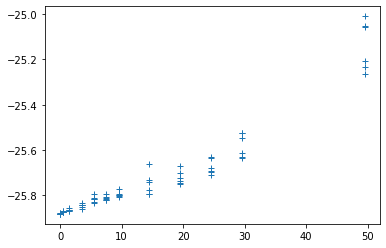

In [170]:
def log_complicated(N, alpha, gamma):
    return np.log(alpha/(N**2)+gamma)

def log_complicated_lin(t, alpha):
    return 2*alpha*t

N0 = popt[0]
alpha = popt[1]
gamma = popt[2]
holdTimeList = np.linspace(0.5, 50, 200)
plt.figure()
plt.plot(holdTimeList_Polarized, log_complicated(NCountList_Polarized, alpha, gamma), '+')
#plt.plot(holdTimeList_Polarized, log_complicated_lin(holdTimeList_Polarized, alpha)+log_complicated(N0, alpha, gamma), '*')
plt.show()

In [116]:
N0_guess = max(NCountList_Polarized)
time_guess = max(holdTimeList_Polarized)
NCountList_Polarized = NCountList_Polarized[holdTimeList_Polarized < 40]
holdTimeList_Polarized = holdTimeList_Polarized[holdTimeList_Polarized < 40]
N0_min = NCountList_Polarized[holdTimeList_Polarized == 0.5].mean()
popt_test, pcov_test = curve_fit(N_polarized, holdTimeList_Polarized, NCountList_Polarized,
                       p0 = [N0_guess, 1/time_guess, 1/(N0_guess**2*time_guess)],
                       bounds=([0, 0, 0] , [np.inf, np.inf, np.inf])
                      )
perr = np.sqrt(np.diag(pcov))
print(popt)
print("The ratio between exponential decay / 3-body decay is " + str(round(popt[2]*(popt[0])**2/(popt[1]),1)))

array([118933., 131354.,  53738.,  54679.,  54546.,  43819.,  48764.,
        26971.,  27875.,  42382.,  32906.,  39670.,  57453., 126928.,
        35010.,  97920.,  55003.,  98975.,  45375.,  61023.,  68041.,
        85350.,  95501.,  36512.,  93937.,  59405.,  67497.,  38917.,
        54616.,  62203., 126218.,  32540.,  61853.,  26841.,  38091.,
        54931., 107713.,  35690.,  75146.,  62218., 107653.,  31381.,
        50371.,  69390., 113113.,  58221.,  37549.,  73935.,  75128.,
        82188.,  96944.,  90481.,  32615., 102829., 110424.,  59302.,
       125439.,  54315.,  61029.,  41056.,  42890.,  44474.,  32802.,
        56563., 103667., 118937.])

In [96]:
N_polarized(0, N0_min, 10, 1)

124634.83729883669

In [129]:
getHoldTimeList(imageIDList_Mixture)

array([20. , 10. ,  8. ,  1. , 30. ,  4. , 50. , 30. ,  8. ,  4. ,  0.5,
       10. ,  2. , 50. , 50. , 30. , 10. ,  1. ,  2. , 25. ,  1. ,  2. ,
       20. , 30. ,  1. ,  4. ,  4. ,  8. , 10. ,  6. ,  0.5, 25. ,  8. ,
       15. ,  2. , 30. , 20. , 15. ,  4. , 20. ,  8. , 30. , 15. , 25. ,
        1. , 20. , 15. , 15. ,  0.5, 15. ,  6. , 50. , 25. ,  2. ,  2. ,
       25. ,  4. ,  8. ,  0.5,  6. , 25. ,  0.5, 10. , 50. ,  6. ,  0.5,
        1. , 20. ,  6. , 10. ,  6. , 50. ])

In [131]:
getHoldTimeList(imageIDList_Polarized)

array([ 0.5,  0.5, 15. ,  8. ,  6. , 15. , 10. , 30. , 30. , 15. , 30. ,
       25. ,  8. ,  0.5, 15. ,  2. , 10. ,  1. , 50. , 20. ,  6. ,  4. ,
        2. ,  2. , 25. ,  2. ,  8. ,  6. , 20. , 50. , 10. ,  8. ,  0.5,
       25. ,  6. , 30. , 25. , 10. , 50. ,  1. , 20. ,  4. ,  8. , 50. ,
        1. , 30. , 15. , 50. ,  6. ,  1. , 10. , 25. ,  4. ,  4. , 50. ,
        4. ,  2. ,  4. , 30. ,  2. ,  1. ,  6. ,  0.5, 15. ,  8. , 20. ,
       20. , 20. , 25. , 10. ,  1. ,  0.5])

In [5]:
mydb = mysql.connector.connect(host = "localhost",
                        user = "student",
                        password = "w0lfg4ng",
                        database = "imagesdypoledatabase",
                        auth_plugin = 'mysql_native_password')
    #print('Local connection established')

NotSupportedError: Authentication plugin 'caching_sha2_password' is not supported